In [9]:
from sentinelhub import SHConfig

config = SHConfig()

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

In [13]:
def plot_image(image, factor=1.0, clip_range=None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [6]:
betsiboka_coords_wgs84 = [46.16, -16.15, 46.51, -15.58]

In [7]:
resolution = 60
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {betsiboka_size} pixels') 

Image shape at 60 m resolution: (631, 1047) pixels


In [10]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2020-06-12', '2020-06-13'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

In [11]:
true_color_imgs = request_true_color.get_data()

In [12]:
print(f'Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.')
print(f'Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}')

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (1047, 631, 3)


Image type: uint8


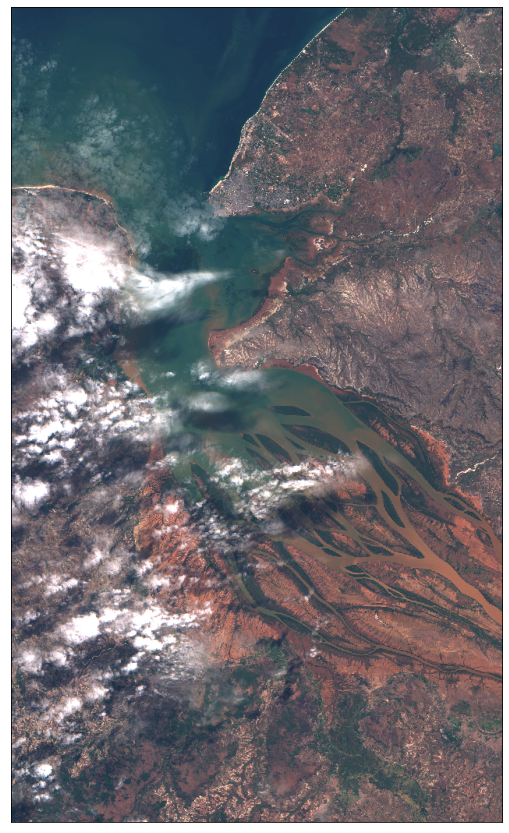

In [14]:
image = true_color_imgs[0]
print(f'Image type: {image.dtype}')

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5/255, clip_range=(0,1))

In [15]:
evalscript_clm = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04", "CLM"],
    output: { bands: 3 }
  }
}

function evaluatePixel(sample) {
  if (sample.CLM == 1) {
    return [0.75 + sample.B04, sample.B03, sample.B02]
  }
  return [3.5*sample.B04, 3.5*sample.B03, 3.5*sample.B02];
}
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_clm,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2020-06-12', '2020-06-13'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

In [16]:
data_with_cloud_mask = request_true_color.get_data()

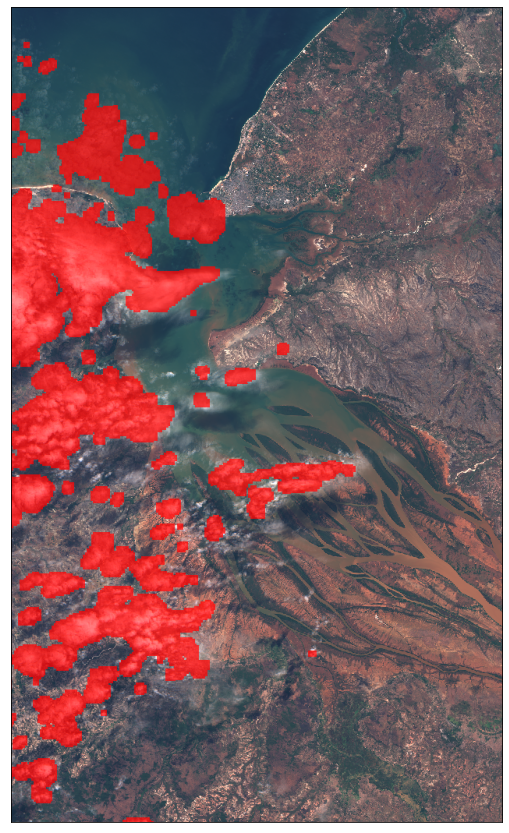

In [17]:
plot_image(data_with_cloud_mask[0], factor=1/255)